In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('car_price.csv')
df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized-losses  205 non-null    object 
 2   make               205 non-null    object 
 3   fuel-type          205 non-null    object 
 4   aspiration         205 non-null    object 
 5   num-of-doors       205 non-null    object 
 6   body-style         205 non-null    object 
 7   drive-wheels       205 non-null    object 
 8   engine-location    205 non-null    object 
 9   wheel-base         205 non-null    float64
 10  length             205 non-null    float64
 11  width              205 non-null    float64
 12  height             205 non-null    float64
 13  curb-weight        205 non-null    int64  
 14  engine-type        205 non-null    object 
 15  num-of-cylinders   205 non-null    object 
 16  engine-size        205 non

In [3]:
# 取出 4 項屬性
features = ['width', 'height', 'horsepower', 'price']
df = df[features]

# 計算遺漏值(?)數目
df.isin(['?']).sum()

width         0
height        0
horsepower    2
price         4
dtype: int64

In [4]:
# 將遺漏值(?)取代為 NaN，並刪除有 NaN 的列
df = df.replace('?', np.nan).dropna()
print('汽車價格形式：', df.shape)

汽車價格形式： (199, 4)


In [5]:
# 型態轉換(object -> float64)
print('== 資料型態(轉換前) ==\n', df.dtypes)
df['horsepower'] = df['horsepower'].astype(float)
df['price'] = df['price'].astype(float)
print('\n== 資料型態(轉換後) ==\n', df.dtypes)

== 資料型態(轉換前) ==
 width         float64
height        float64
horsepower     object
price          object
dtype: object

== 資料型態(轉換後) ==
 width         float64
height        float64
horsepower    float64
price         float64
dtype: object


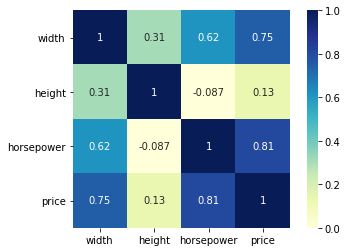

In [6]:
# 相關係數
import matplotlib.pyplot as plt
import seaborn as sns

corr = df.corr()
sns.heatmap(corr, annot=True, vmax=1, vmin=0, square=True, cmap='YlGnBu')

In [7]:
# 切割訓練集、測試集
from sklearn.model_selection import train_test_split

X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.4, 
                                                    random_state=0)
X_train.shape

(119, 3)

In [8]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

def adj_r2(r2, n, k):
    return 1 - (n-1)*(1-r2)/(n-k-1)

r2 = lr.score(X_train, y_train)
print('Adj. R2(train):', adj_r2(r2, X_train.shape[0], X_train.shape[1]))
r2 = lr.score(X_test, y_test)
print('Adj. R2(test):', adj_r2(r2, X_test.shape[0], X_test.shape[1]))

Adj. R2(train): 0.7242317588565197
Adj. R2(test): 0.7861203624844124


In [9]:
# 迴歸係數
print('迴歸係數\n', pd.Series(lr.coef_, index=X.columns))
print('截距:', lr.intercept_)

迴歸係數
 width         1411.435715
height         257.330363
horsepower     110.088497
dtype: float64
截距: -105240.01512893486


Text(0, 0.5, 'Residual')

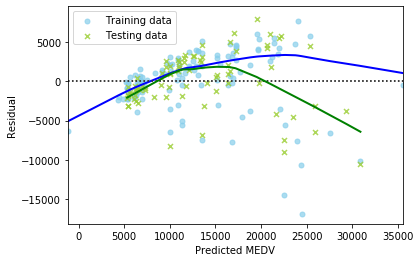

In [10]:
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
y_train_resid = y_train_pred - y_train
y_test_resid = y_test_pred - y_test 

sns.residplot(y_train_pred, y_train_resid, lowess=True, 
              color="skyblue", label='Training data', 
              scatter_kws={'s':25, 'alpha':0.7}, 
              line_kws={'color':'b', 'lw':2})
sns.residplot(y_test_pred, y_test_resid, lowess=True, 
             color="yellowgreen", label='Testing data', 
              scatter_kws={'s':25, 'marker':'x'}, 
              line_kws={'color':'g', 'lw':2})
plt.legend()
plt.xlabel('Predicted MEDV')
plt.ylabel('Residual')

R^2(train): 0.9664754167591599
R^2(test): 0.9850031278294877


Text(0, 0.5, 'Residual')

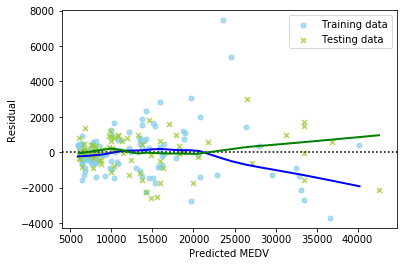

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

reg = RandomForestRegressor(n_estimators=100,# default 
                            criterion='mse', # default
                            random_state=0, 
                            n_jobs=-1)
reg.fit(X, y)
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)
r2 = adj_r2(r2_score(y_train, y_train_pred), X.shape[0], 
X.shape[1])
print('R^2(train):', r2)
r2 = adj_r2(r2_score(y_test, y_test_pred), X.shape[0], 
X.shape[1])
print('R^2(test):', r2)

y_train_resid = y_train_pred - y_train
y_test_resid = y_test_pred - y_test 
sns.residplot(y_train_pred, y_train_resid, lowess=True, 
              color="skyblue", label='Training data', 
              scatter_kws={'s': 25, 'alpha':0.7}, 
              line_kws={'color': 'b', 'lw':2})
sns.residplot(y_test_pred, y_test_resid, lowess=True, 
              color="yellowgreen", 
label='Testing data', 
              scatter_kws={'s':25, 'marker':'x'}, 
              line_kws={'color':'g', 'lw':2})
plt.legend()
plt.xlabel('Predicted MEDV')
plt.ylabel('Residual')